# Curvas de ROC

La curva de ROC se genera graficando Sensibilidad (vardaderos positivos) contra 1 - Especificidad (verdaderos negativos). Esto se hace con un umbral deslizante, de tal modo que los resultados no dependen del algoritmo de umbralización.

Usaremos curvas de ROC para determinar los parametros para el filtro **Top Hat**. Para esto tenemos que tener nuestro ground truth.

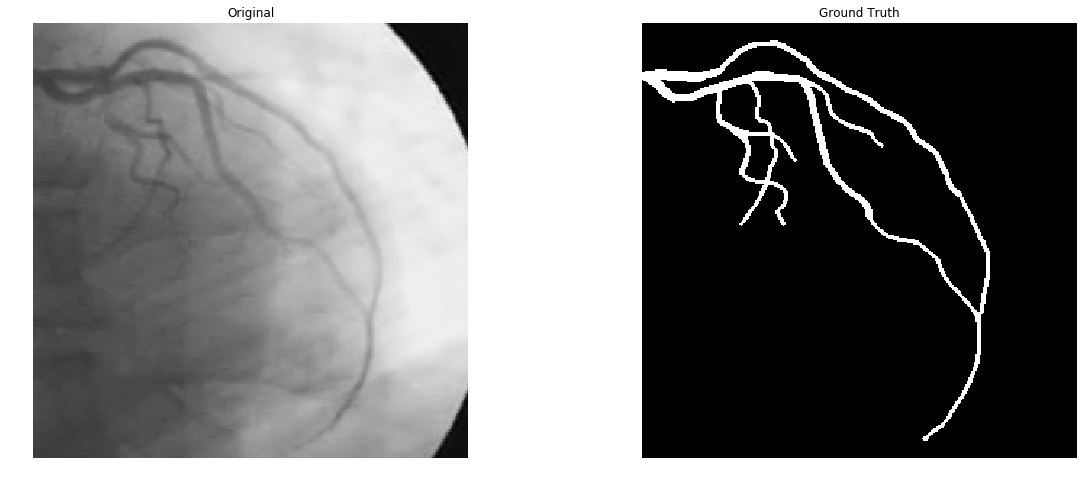

In [255]:
from skimage import io
from skimage import img_as_ubyte
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

filename = './Set2_imagenes/Angios/2.png'
truthname = './Set2_imagenes/Angios/2_gt.png'
img = img_as_ubyte(rgb2gray(io.imread(filename)))
gth = img_as_ubyte(rgb2gray(io.imread(truthname)))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.imshow(img, cmap='gray')
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(gth, cmap='gray')
ax2.axis('off')
ax2.set_title('Ground Truth')

plt.show()

Tenemos multiples valores para el tamaño del elemento estructurante, para cada uno de estos aplicamos **topHat** y umbralizamos con todos los valores de la escala de grises. En este caso de 0 a 255.

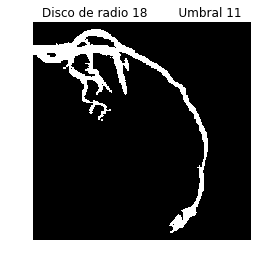

True Positive:  0.8236817325800376 	 True Negative:  0.9590680100755667


In [256]:
from numba import jit
@jit(nopython = True, nogil=True, parallel=True)
def getTPTN(imgN, gth):
    tp, tn = 0, 0
    p, n = 0, 0
    for i in range(imgN.shape[0]):
        for j in range(imgN.shape[0]):
            if(gth[i, j] == 255):
                p += 1
                tp += int(imgN[i, j])
            else:
                n += 1
                tn += 1 - int(imgN[i, j])
    return (tp/p, tn/n)
# from __future__ import print_function
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets

from morphological import *
from skimage.morphology import remove_small_objects

img2 = black_topHat(img, getDiamondSE(18))
imgF = remove_small_objects(img2 >= 11, 1000)
plt.imshow(imgF, cmap='gray')
plt.title('Disco de radio 18        Umbral 11')
plt.axis('off')
plt.show()
tp, tn = getTPTN(imgF, gth)
print("True Positive: ", tp, "\t True Negative: ", tn)

### Curva de ROC para una sola imágen

Fijamos el umbral en *18*

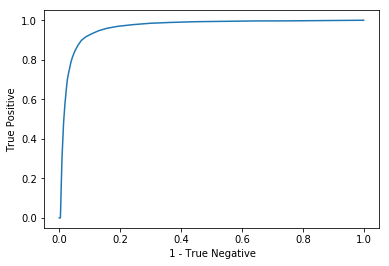

Area  0.963163110107


In [307]:
def get_sliding_threshold_rates(image, ground, rateFn, remove_small):
    sl = np.zeros((2, 255))
    for i in range(0, 255): #should make dynamic
        imgF = image >= i
        if remove_small: imgF = remove_small_objects(imgF, 1000)
        sl[0, i], sl[1, i] = rateFn(imgF, ground)
    return sl
# values is array with [x, y], where x and y are vectors
def area_under_curve(values):
    area = 0
    for i in range(1, values.shape[1]):
        area += (values[0, i-1] + values[0, i])*(values[1, i-1] - values[1, i])/2
    return area
rates = get_sliding_threshold_rates(img2 , gth, getTPTN, False)
rates[1] = 1 - rates[1]
np.sort(rates) 
plt.plot(rates[1], rates[0]) #x, y#
plt.xlabel(" 1 - True Negative")
plt.ylabel("True Positive")
plt.show()
print("Area ", area_under_curve(rates))

Para un conjunto de imágenes con nombres que conocemos previamente y podemos generar. Al igual, con un tamaño de elemento estructurante fijo en *18*

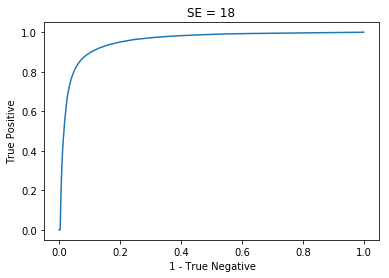

Area  0.954596353246
CPU times: user 9.57 s, sys: 25.6 ms, total: 9.6 s
Wall time: 9.63 s


In [311]:
%%time
nimgs = 20
imgs = [None] * nimgs
truths = [None] * nimgs
for i in range(0, nimgs): #tenemos imagenes con nombres <i>.pgn y <i>_gt.png
    fileName = './Set2_imagenes/Angios/' + str(i+1) + '.png'
    truthName = './Set2_imagenes/Angios/' + str(i+1) + '_gt.png'
    imgs[i] = img_as_ubyte(rgb2gray(io.imread(fileName)))
    truths[i] = img_as_ubyte(rgb2gray(io.imread(truthName)))

se_size = 18
rates = np.zeros((2, 255))
for i in range(nimgs):
    topHat = black_topHat(imgs[i], getDiamondSE(se_size))
    rates += get_sliding_threshold_rates(topHat , truths[i], getTPTN, False)/ nimgs

rates[1] = 1 - rates[1]
np.sort(rates)

plt.plot(rates[1], rates[0]) #x, y#
plt.title("SE = 18")
plt.xlabel(" 1 - True Negative")
plt.ylabel("True Positive")
plt.show()
print("Area ", area_under_curve(rates))

Ahora juntamos todo

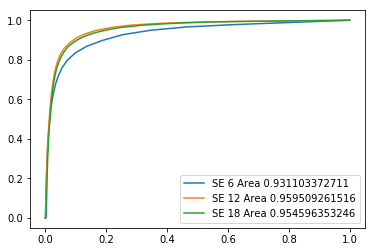

CPU times: user 1min 56s, sys: 481 ms, total: 1min 57s
Wall time: 1min 58s


In [320]:
%%time
nimgs = 20
imgs = [None] * nimgs
truths = [None] * nimgs
for i in range(0, nimgs): #tenemos imagenes con nombres <i>.pgn y <i>_gt.png
    fileName = './Set2_imagenes/Angios/' + str(i+1) + '.png'
    truthName = './Set2_imagenes/Angios/' + str(i+1) + '_gt.png'
    imgs[i] = img_as_ubyte(rgb2gray(io.imread(fileName)))
    truths[i] = img_as_ubyte(rgb2gray(io.imread(truthName)))
    
scores = [None] * 20
fig, ax = plt.subplots()
for se_size in range(1, 21): #test for sizes form 1 to 20
    rates = np.zeros((2, 255))
    for i in range(nimgs):
        topHat = black_topHat(imgs[i], getDiamondSE(se_size))
        rates += get_sliding_threshold_rates(topHat , truths[i], getTPTN, False)/ nimgs
    rates[1] = 1 - rates[1]
    np.sort(rates)
    scores[se_size-1] = area_under_curve(rates)
    if se_size % 6 is 0 : ax.plot(rates[1], rates[0], label='SE '+str(se_size)+' Area '+ str(scores[se_size-1]))
ax.legend(loc='lower right')
plt.show()

In [316]:
best = 0
for i in range(len(scores)):
    if scores[i] > scores[best]: best = i
print("Optimo en :", best + 1, " con Area de " , scores[best])

Optimo en : 12  con Area de  0.959509261516
